In [1]:
%matplotlib inline
from SALib.sample import saltelli
from batchrunner import BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from model import BeeEvolutionModel
from agents import *

## OFAT Sensitivity Analysis(Local Analysis)

In [2]:
problem = {
    'num_vars': 4,
    'names': ['alpha', 'forager_royal_ratio', 'growth_factor', 'resource_variability'],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0, 0.5]],
    'nominal_value': [0.5, 0.5, 0.5, 0.25]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
distinct_samples = 20
seed = 20

# Set the outputs
model_reporters = {"Total Workers": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Worker)]),
                   "Total Queens": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Queen)]),
                   "Total Drones": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Drone)]),
                   "Total Fertilized Queens": lambda m: m.get_total_fertilized_queens()}

data = {}

for i, var in enumerate(problem['names']):

    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    fixed_parameters = {}
    for j, var_ in enumerate(problem['names']):
        if j != i:
            fixed_parameters[var_] = problem['nominal_value'][j]
    fixed_parameters["seed"] = seed
    
    variable_parameters=[{var: sample} for sample in samples]
    
    batch = BatchRunnerMP(BeeEvolutionModel, 
                        fixed_parameters=fixed_parameters,
                        iterations=replicates,
                        variable_parameters=variable_parameters,
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()
    

BatchRunner MP will use 6 processors.


400it [29:33,  4.43s/it]


BatchRunner MP will use 6 processors.


400it [36:38,  5.50s/it]


BatchRunner MP will use 6 processors.


400it [30:42,  4.61s/it]


BatchRunner MP will use 6 processors.


400it [31:41,  4.75s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'ofat_output'

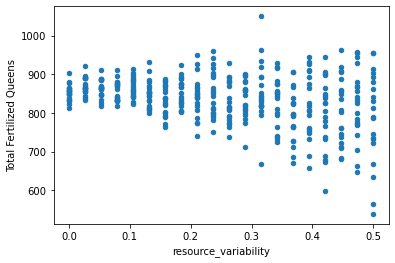

In [4]:
data['resource_variability'].plot.scatter(x='resource_variability', y='Total Fertilized Queens')

# how to save
# np.savez('1ofat_output', data=data, problem=problem, model_reporters=list(model_reporters.keys()))

IndexError: index 3 is out of bounds for axis 0 with size 3

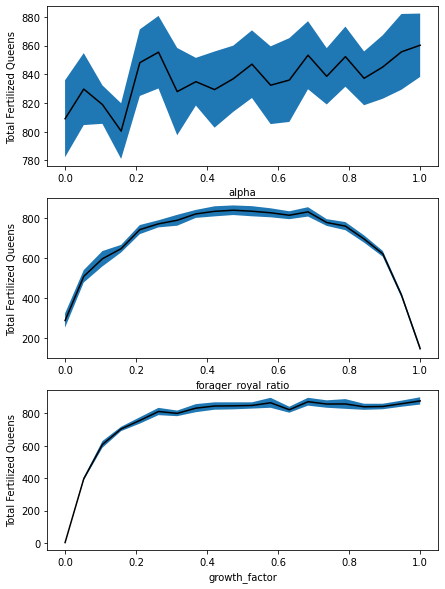

In [5]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(3, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)

for param in ["Total Fertilized Queens"]:
    plot_all_vars(data, param)
    plt.savefig("results/sa_local.jpg", dpi="figure")
    plt.show()

In [23]:
# how to load the data
# data is dictionary of dataframes

results = np.load('ofat_output.npz', allow_pickle=True)
data = results['data'][()]